# CNN-VAE on HUTUBS dataset (Chen et al. 2019)

In [1]:
%load_ext autoreload
%autoreload 2

In [81]:
import os
import time
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio
from IPython.display import display

from utils_data import load_hutubs_yamo
from utils_model_1d import create_autoencoder_dense, create_autoencoder_resnet, create_autoencoder_inception, \
                           create_cvae_dense, create_cvae_resnet, create_cvae_inception
from utils_train import train_model
from utils_plot import plot_reconstructions_chen2019, plot_reconstructions_cvae, \
                       plot_xcorr, plot_xcorr_cvae, plot_latent_space

In [3]:
## some useful functions
def normalize_hrtf(hrtf, x_mean, x_std):
    hrtf_n = hrtf.copy()
    hrtf_n -= x_mean
    hrtf_n /= x_std
    return hrtf_n

def denormalize_hrtf(hrtf, x_mean, x_std):
    hrtf_n = hrtf.copy()
    hrtf_n *= x_std
    hrtf_n += x_mean
    return hrtf_n

## Load data

In [4]:
# show all possible setups
azimuths = sio.loadmat('./data/hutubs_hrtf/configs.mat')['azimuths'][0]
elevations = sio.loadmat('./data/hutubs_hrtf/configs.mat')['elevations'][0]
freqs = sio.loadmat('./data/hutubs_hrtf/configs.mat')['f'][0]
print(azimuths) 
print(elevations)
print(len(azimuths[::5]) * (len(elevations[::2])-2))

[  0   5  10  15  20  25  30  35  40  45  50  55  60  65  70  75  80  85
  90  95 100 105 110 115 120 125 130 135 140 145 150 155 160 165 170 175
 180 185 190 195 200 205 210 215 220 225 230 235 240 245 250 255 260 265
 270 275 280 285 290 295 300 305 310 315 320 325 330 335 340 345 350 355]
[-85 -80 -75 -70 -65 -60 -55 -50 -45 -40 -35 -30 -25 -20 -15 -10  -5   0
   5  10  15  20  25  30  35  40  45  50  55  60  65  70  75  80  85  90]
240


In [5]:
# load HRTFs from HUTUBS 
filters = {
    'ears': ['left'],
    #'ids': range(1,31),
    'azimuths': (np.arange(-70,71) % 360),
    'elevations': np.arange(-45,46)
}
print(filters)
(x_train, y_train), (x_test, y_test) = load_hutubs_yamo(
    dataset_path='./data/hutubs_hrtf/', 
    anthropometrics_path='./data/hutubs_measures.csv', 
    data_content='hrtfs',
    user_filters=filters)

# remove neighbors
x_train = x_train[:,3,3,:]
x_test = x_test[:,3,3,:]

{'ears': ['left'], 'azimuths': array([290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302,
       303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315,
       316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328,
       329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341,
       342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354,
       355, 356, 357, 358, 359,   0,   1,   2,   3,   4,   5,   6,   7,
         8,   9,  10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,
        21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,
        34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,
        47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,
        60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70]), 'elevations': array([-45, -44, -43, -42, -41, -40, -39, -38, -37, -36, -35, -34, -33,
       -32, -31, -30, -29, -28, -27, -26, -25, -24, -23, -22, -21, -20,
       -19, -18, -17, -16, 

  4%|▍         | 49590/1154790 [01:25<31:47, 579.35it/s]


In [6]:
# normalize
x_train_mean = x_train.mean()
x_train_std = x_train.std()
x_train = normalize_hrtf(x_train, x_train_mean, x_train_std)
x_test = normalize_hrtf(x_test, x_train_mean, x_train_std)
print(x_train_mean, x_train_std)

# show resulting data shapes
print('train set:', x_train.shape)
print('test set: ', x_test.shape)

n_frequencies = x_train.shape[1]

-3.5637848952544826 13.789414229857954
train set: (36917, 128)
test set:  (12673, 128)


In [7]:
# add normalized azimuth/elevation angles
stddeg = azimuths.std()
y_train['elevation_norm'] = y_train['elevation'] / stddeg
y_train['azimuth_norm'] = [a/stddeg if a<=180 else (a-360)/stddeg for a in y_train['azimuth']]
y_test['elevation_norm'] = y_test['elevation'] / stddeg
y_test['azimuth_norm'] = [a/stddeg if a<=180 else (a-360)/stddeg for a in y_test['azimuth']]

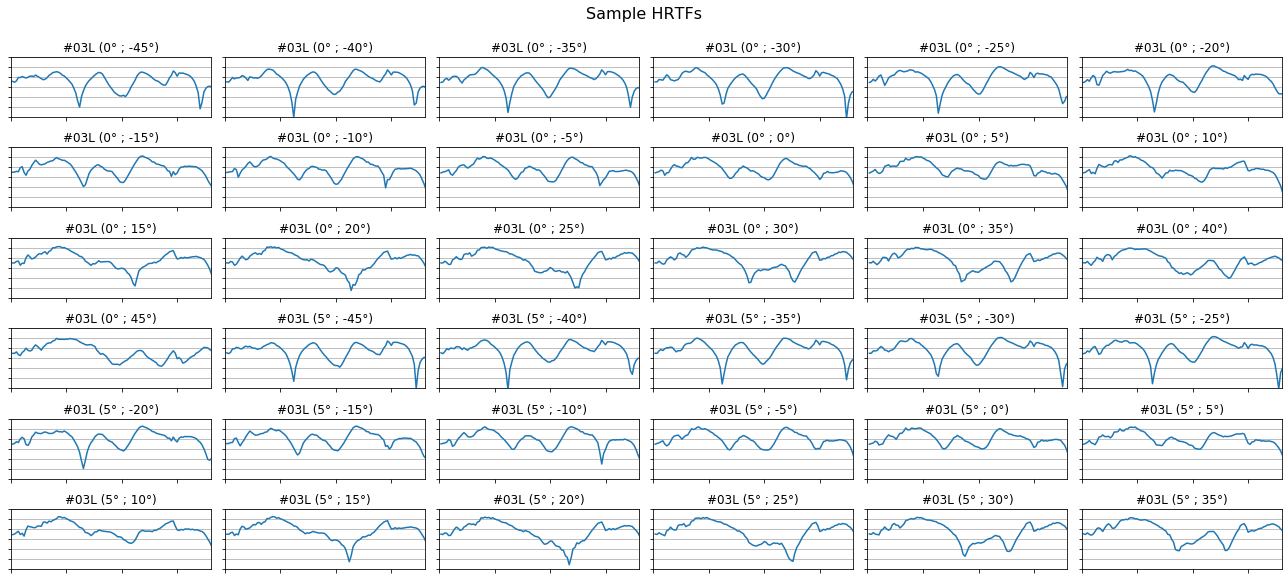

In [8]:
nr, nc = 6, 6
w = 18
h = w / 2.2
f = sio.loadmat('./data/hutubs_hrtf/configs.mat')['f'][0]
offs = 30

fig, ax = plt.subplots(nr, nc, figsize=(w, h))
for i, a in enumerate(ax.flatten()):
    a.plot(f, x_train[i])
    a.set_title('#{:02}{} ({:.0f}° ; {:.0f}°)'.format(
            y_train['id'].iloc[i], y_train['ear'].iloc[i][0].upper(),
            y_train['azimuth'].iloc[i], y_train['elevation'].iloc[i]))    
    a.set_ylim([-1.2, 1.2])
    a.set_xlim([0, 18000])
    a.set_yticks(np.arange(-1.5, 1.51, 0.5))
    a.yaxis.grid()
    a.set_yticklabels([])
    a.set_xticklabels([])
    #a.axis('off')
fig.suptitle('Sample HRTFs', fontsize=16)
fig.tight_layout(rect=[0,0,1,0.94])


## Create network

In [87]:
# network parameters
modelname = 'chen2019'
filters_layers = [256, 192, 128, 96, 64, 48, 32]
n_latent = 16

# create 1d net
encoder, decoder, vae = create_autoencoder_dense(n_input=n_frequencies, 
                                                  filters_layers=filters_layers, 
                                                  n_latent=n_latent,
                                                  gen_plots=True)

# pre-compute some info for training
curr_epoch = 0
log_id = int(time.time()) % 99999999
tensorboard_destination = f'./logs/{log_id}'


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 128)          0                                            
__________________________________________________________________________________________________
encoder_0_dense (Dense)         (None, 256)          33024       encoder_input[0][0]              
__________________________________________________________________________________________________
encoder_0_bn (BatchNormalizatio (None, 256)          1024        encoder_0_dense[0][0]            
__________________________________________________________________________________________________
encoder_0_act (Activation)      (None, 256)          0           encoder_0_bn[0][0]               
__________________________________________________________________________________________________
encoder_1_

## Train network

In [88]:
# training parameters
batch_size = x_train.shape[0] // 64
print(batch_size)
epochs = 200
validation_freq = 5
earlystopping_patience = -50
checkpoint_destination = None #'./models/{epoch.h5}'
cuda_device = '2'
tqdm_bar = True
# train the autoencoder
epochs_range = [curr_epoch, curr_epoch+epochs]
print(f'Training log: {tensorboard_destination}')
print(f'Training from {epochs_range[0]} to {epochs_range[1]}..')
trainig_history = train_model(vae, x_train, y_train[['azimuth_norm', 'elevation_norm']], 
                              x_test, y_test[['azimuth_norm', 'elevation_norm']], 
                              batch_size, epochs_range=epochs_range,
                              validation_freq=validation_freq,
                              tqdm_bar=tqdm_bar,
                              earlystopping_patience=earlystopping_patience, 
                              checkpoint_destination=checkpoint_destination, 
                              tensorboard_destination=tensorboard_destination, 
                              cuda_device=cuda_device)

curr_epoch += trainig_history.index[-1]

576
Training log: ./logs/78067268
Training from 0 to 200..


loss: 0.1575, val_loss: 0.1597: 100%|██████████| 200/200 [08:55<00:00,  2.68s/it]


## Plot results

minimum loss:  0.15714612621391705


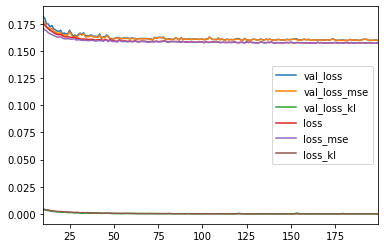

In [89]:
trainig_history.iloc[10:].plot()
print('minimum loss: ', trainig_history['loss'].min())

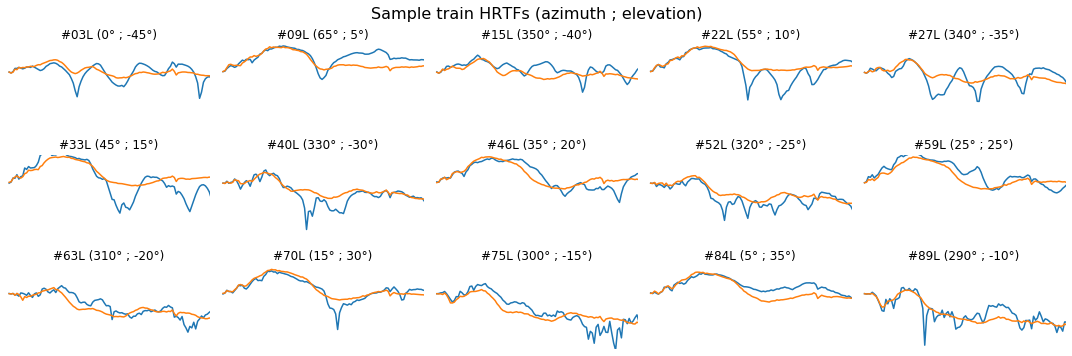

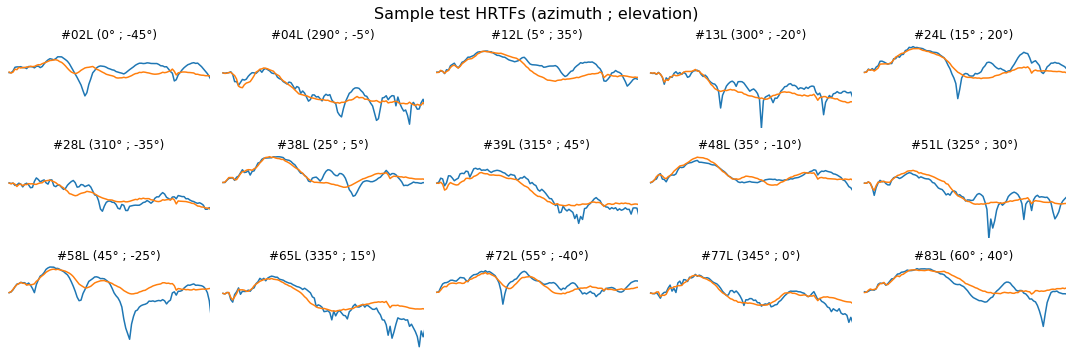

In [90]:
# take data
data_train = (x_train, y_train)
data_test = (x_test, y_test)

# plot reconstructions
fig, axs = plt.subplots(3, 5, figsize=(15, 5))
plot_reconstructions_chen2019(encoder, decoder, data_train, axs=axs, batch_size=batch_size, x_train_mean=x_train_mean, x_train_std=x_train_std)
fig.tight_layout()
fig.suptitle('Sample train HRTFs (azimuth ; elevation)', fontsize=16)
fig.tight_layout(rect=[0,0,1,0.95])

fig, axs = plt.subplots(3, 5, figsize=(15, 5))
plot_reconstructions_chen2019(encoder, decoder, data_test, axs=axs, batch_size=batch_size, x_train_mean=x_train_mean, x_train_std=x_train_std)
fig.tight_layout()
fig.suptitle('Sample test HRTFs (azimuth ; elevation)', fontsize=16)
fig.tight_layout(rect=[0,0,1,0.95])

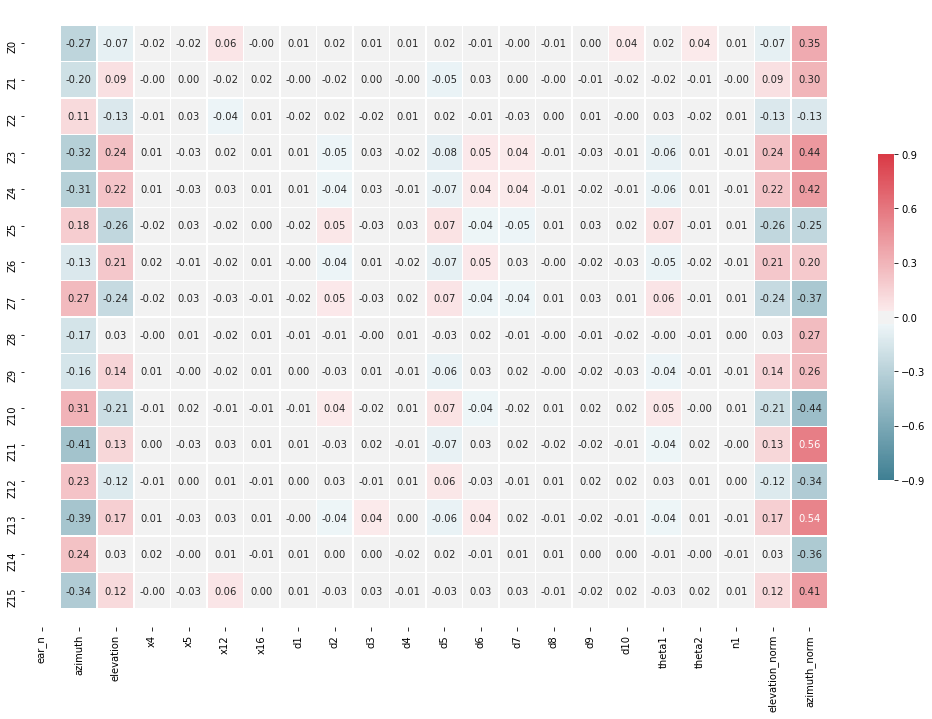

In [91]:
# data to use
drop_cols = ['ear', 'id', 'x6', 'x7', 'x8', 'x9', 'x14', 'x17', 'x2', 'x3', 'x1']
#data_train = (x_train, y_train.drop(columns=['elevation', 'azimuth', 'xoffs', 'yoffs', *drop_cols]).astype(float))
data_train = (x_train, y_train.drop(columns=drop_cols).astype(float))
data_test = (x_test, y_test.drop(columns=drop_cols).astype(float))

# plot correlation
fig, ax = plt.subplots(1, 1, figsize=(18, 12))
corr = plot_xcorr(encoder, data_test, ax,
           batch_size=batch_size, pca=False,
           labels=True)

In [92]:
def spectral_distortion(hrtf_true, hrtf_pred, freqs, f_range):
    fmin, fmax = f_range
    # get bins in range
    f_idx = []
    for i,f in enumerate(freqs):
        if f > fmin and f < fmax:
            f_idx.append(i)
    # formula: sqrt(1/N * sum(square(H_true(f) - H_pred(f))))
    sd_db = np.sqrt((1/len(f_idx)) * np.sum(np.power(hrtf_true[:,f_idx] - hrtf_pred[:,f_idx], 2), axis=1))
    # dB to linear
    #sd = 10 ** (sd_db/20)
    return sd_db

# test
f_range = (3000, 16000)
z_mean, z_log_var = encoder.predict(x_train, batch_size=512)
z_sample = np.concatenate((z_mean, y_train[['azimuth_norm', 'elevation_norm']]), axis=1)
x_pred = decoder.predict(z_sample)

# store SD results
res_train = y_train[['id', 'elevation', 'azimuth']].copy()
res_train['SD'] = spectral_distortion(denormalize_hrtf(x_train, x_train_mean, x_train_std), denormalize_hrtf(x_pred, x_train_mean, x_train_std), freqs, f_range)
print('mean SD (train) = ', res_train['SD'].mean())

mean SD (train) =  5.11019698103282


In [93]:
# test
f_range = (3000, 16000)
z_mean, z_log_var = encoder.predict(x_test, batch_size=512)
z_sample = np.concatenate((z_mean, y_test[['azimuth_norm', 'elevation_norm']]), axis=1)
x_pred = decoder.predict(z_sample)

# store SD results
res_train = y_test[['id', 'elevation', 'azimuth']].copy()
res_train['SD'] = spectral_distortion(denormalize_hrtf(x_test, x_train_mean, x_train_std), denormalize_hrtf(x_pred, x_train_mean, x_train_std), freqs, f_range)
print('mean SD (test)= ', res_train['SD'].mean())

mean SD (test)=  5.16081472782484


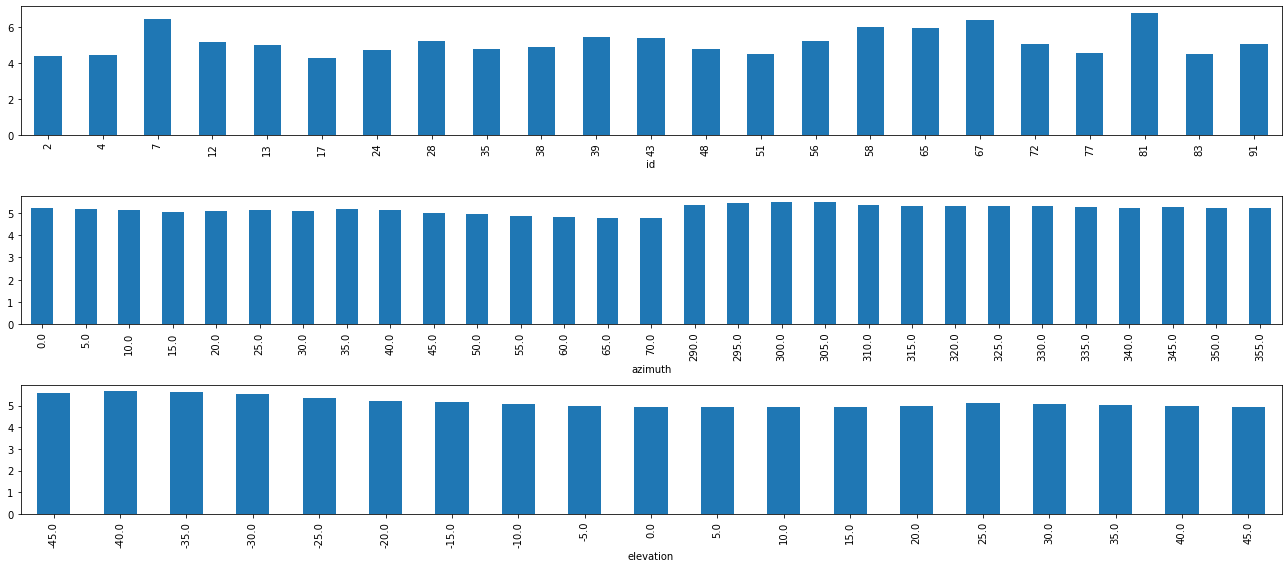

In [94]:
# spectral distortion on train data (various sub-groupings)
fig, axs = plt.subplots(3,1, figsize=(18,8))
res_train.groupby(['id']).mean()['SD'].plot.bar(ax=axs[0])
res_train.groupby(['azimuth']).mean()['SD'].plot.bar(ax=axs[1])
res_train.groupby(['elevation']).mean()['SD'].plot.bar(ax=axs[2])
fig.tight_layout()

/home/rmicci18/miniconda3/envs/hrtf/lib/python3.7/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


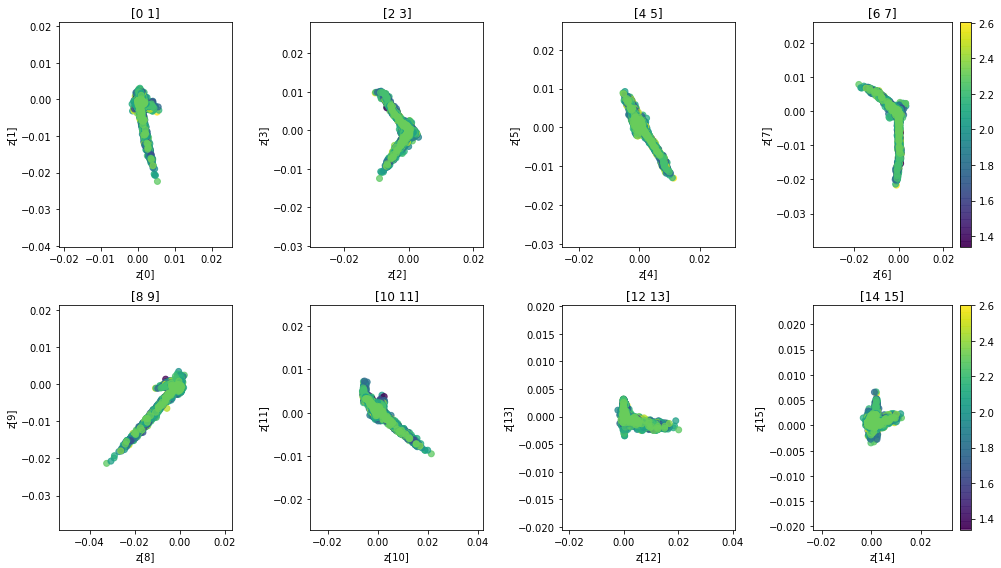

In [95]:
#data_train = (x_train, y_train['id'].astype('category').cat.codes)
#data_test = (x_test, y_test['id'].astype('category').cat.codes)
data_train = (x_train, y_train['d4'])

# plot latent dims
fig, axs = plt.subplots(2, n_latent//4, figsize=(14, 8))
combinations = np.arange(n_latent).reshape((n_latent//2, 2))
for i, dims in enumerate(combinations):
#for dims in [[14, 15]]:
    dims += 0
    plot_latent_space(encoder, data_train, axs.flatten()[i],
                      batch_size=batch_size, dims=dims,
                      colorbar=(i%4==3), use_pca=False)
fig.tight_layout()

In [ ]:
# take data
data_train = (x_train, y_train)
data_test = (x_test, y_test)

# plot reconstructions
fig, axs = plt.subplots(3, 4, figsize=(18, 6))
#plot_reconstructions_chen2019_3d(encoder, decoder, data_train, axs=axs, batch_size=batch_size, x_train_mean=x_train_mean, x_train_std=x_train_std)
fig.tight_layout()
fig.suptitle('Sample train HRTFs (azimuth ; elevation)', fontsize=16)
fig.tight_layout(rect=[0,0,1,0.95])

fig, axs = plt.subplots(3, 4, figsize=(18, 6))
#plot_reconstructions_chen2019_3d(encoder, decoder, data_test, axs=axs, batch_size=batch_size, x_train_mean=x_train_mean, x_train_std=x_train_std)
fig.tight_layout()
fig.suptitle('Sample test HRTFs (azimuth ; elevation)', fontsize=16)
fig.tight_layout(rect=[0,0,1,0.95])

In [ ]:
# plot PC
data_train = (x_train[::2], y_train['azimuth'].iloc[::2])
data_test = (x_test, y_test['elevation'])
plot_latent_pairs(encoder, data_train,
                  batch_size=batch_size, n_pca=False, n_dim=6, plot_kws=dict(edgecolor='none', alpha=0.5, s=15))

In [ ]:
# TODO:
# - 3d plots
# - hyperparam opt: `talos`
# - noise solo a input
# - train con 'cubo' (elevation, azimuth, frequency) https://www.sciencedirect.com/science/article/pii/S0925231215014940
# - semisupervised learning http://bjlkeng.github.io/posts/semi-supervised-learning-with-variational-autoencoders/
# - inception layers (unabridged) https://becominghuman.ai/understanding-and-coding-inception-module-in-keras-eb56e9056b4b
# - plot: tsne on latent space
# - extract hrtf/hrir
# - plot: hrtf/hrir
# - freq_loss: pearson vs mse?
# - store and load trained model

# - spetral distortion (500, 16k) Hz (viking paper)

In [10]:
## NOTE: only run if there's no existing log file!
logs_df = pd.DataFrame(columns=[
    'modelname', 'input_shape', 'filters_layers', 
    'kernel_size', 'n_latent', 'use_batchnorm', 
    'use_maxpool', 'freq_loss', 'date_time'])
logs_df.index.name = 'log_id'
logs_df.to_pickle('./logs_3d.pkl')

